__https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8__

How to decide which Model is appropriate?

Choosing between PooledOLS and FE/RE: Basically, there are five assumptions for simple linear regression models that must be fulfilled. Two of them can help us in choosing between PooledOLS and FE/RE.

These assumptions are (1) Linearity, (2) Exogeneity, (3a) Homoskedasticity and (3b) Non-autocorrelation, (4) Independent variables are not Stochastic and (5) No Multicolinearity.

If assumption (2) or (3) (or both) are violated, then FE or RE might be more suitable.

Choosing between FE and RE: Answering this question depends on your assumption, if the individual, unobserved heterogeneity is a constant or random effect. But this question can also be answered perfoming the Hausman-Test.

Hausman-Test: In simple termns, the Hausman-Test is a test of endogeneity. By running the Hausman-Test, the null hypothesis is that the covariance between IV(s) and alpha is zero. If this is the case, then RE is preferred over FE. If the null hypothesis is not true, we must go with the FE-model.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels import PooledOLS

In [ ]:
dataset = pd.read_csv("Guns.csv", usecols = ["state", "date", "latitude", "longitude"],index_col = ["state", "date"])

In [56]:
dataset.index = dataset.index.set_levels(pd.to_datetime(dataset.index.levels[1]), level=1)
dataset

latitude  longitude
state          date                           
Pennsylvania   2013-01-01   40.3467   -79.8559
California     2013-01-01   33.9090  -118.3330
Ohio           2013-01-01   41.4455   -82.1377
Colorado       2013-01-05   39.6518  -104.8020
North Carolina 2013-01-07   36.1140   -79.9569
...                             ...        ...
Louisiana      2018-03-31       NaN        NaN
               2018-03-31   31.7537   -93.0836
               2018-03-31   29.9239   -90.0442
Texas          2018-03-31   29.7201   -95.6110
Maine          2018-03-31   44.7293   -69.7691

[239677 rows x 2 columns]

In [57]:
dates = dataset.index.get_level_values("date").to_list()
dataset["date"] = pd.Categorical(dates)

In [58]:
dataset

latitude  longitude       date
state          date                                      
Pennsylvania   2013-01-01   40.3467   -79.8559 2013-01-01
California     2013-01-01   33.9090  -118.3330 2013-01-01
Ohio           2013-01-01   41.4455   -82.1377 2013-01-01
Colorado       2013-01-05   39.6518  -104.8020 2013-01-05
North Carolina 2013-01-07   36.1140   -79.9569 2013-01-07
...                             ...        ...        ...
Louisiana      2018-03-31       NaN        NaN 2018-03-31
               2018-03-31   31.7537   -93.0836 2018-03-31
               2018-03-31   29.9239   -90.0442 2018-03-31
Texas          2018-03-31   29.7201   -95.6110 2018-03-31
Maine          2018-03-31   44.7293   -69.7691 2018-03-31

[239677 rows x 3 columns]

In [59]:
# Perform PooledOLS
exog = sm.tools.tools.add_constant(dataset['latitude'].fillna(0))
endog = dataset['longitude'].fillna(0)
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

In [60]:
pooledOLS_res.summary

Dep. Variable:,longitude,R-squared:,0.3862
Estimator:,PooledOLS,R-squared (Between):,-0.2139
No. Observations:,239677,R-squared (Within):,0.8513
Date:,"Sun, May 22 2022",R-squared (Overall):,0.3862
Time:,15:12:27,Log-likelihood,-1.015e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,1.508e+05
Entities:,51,P-value,0.0000
Avg Obs:,4699.5,Distribution:,"F(1,239675)"
Min Obs:,289.00,,
Max Obs:,1.756e+04,F-statistic (robust):,153.61


In [43]:
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

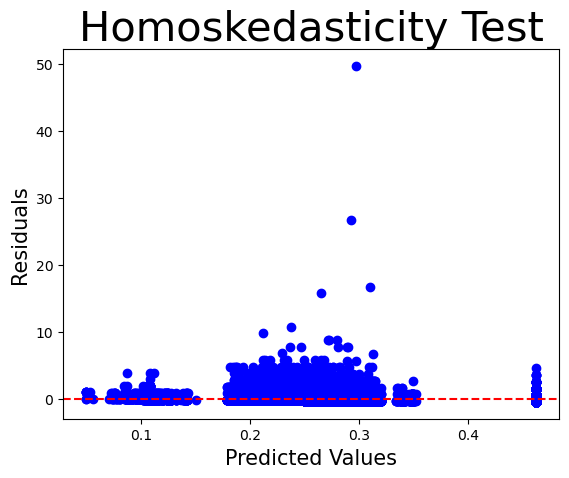

In [64]:
# Homoskedasticity
## Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = "blue")
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel("Predicted Values", fontsize = 15)
ax.set_ylabel("Residuals", fontsize = 15)
ax.set_title("Homoskedasticity Test", fontsize = 30)
plt.show()

In [66]:
## White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(["date"], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['latitude']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset["residual"], exog)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, white_test_results)))
## Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset["residual"], exog)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 24.380443350599514, 'LM p-val': 5.07988631632863e-06, 'F-Stat': 12.191309217527126, 'F p-val': 5.077512235031087e-06}
{'LM-Stat': 16.237246407422766, 'LM p-val': 5.588451915644609e-05, 'F-Stat': 16.238210994513416, 'F p-val': 5.587329187457991e-05}


**Heteroskedasticity: In simple terms, if p < 0.05, then heteroskedasticity is indicated.**

In [87]:
## Non-Autocorrelation
## Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset["residual"]) 
print(durbin_watson_test_results)

1.9699614268460006


**Auto-Correlation: The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).**

*To sum up, assumption 3a and 3b are violated in this sample, so it seems that a FE-/RE-model will be more suitable.*

In [89]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(dataset["latitude"].fillna(0))
endog = dataset["longitude"].fillna(0)
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:              longitude   R-squared:                        0.9384
Estimator:              RandomEffects   R-squared (Between):             -0.4658
No. Observations:              239677   R-squared (Within):               0.9384
Date:                Sun, May 22 2022   R-squared (Overall):              0.3118
Time:                        17:14:37   Log-likelihood                -6.731e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.652e+06
Entities:                          51   P-value                           0.0000
Avg Obs:                       4699.5   Distribution:                F(1,239675)
Min Obs:                       289.00                                           
Max Obs:                    1.756e+04   F-statistic (robust):          3.652e+06
                            

In [92]:
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
 
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 

print("chi-Squared: " + str(hausman_results[0]))
print("degrees of freedom: " + str(hausman_results[1]))
print("p-Value: " + str(hausman_results[2]))

chi-Squared: -2.004020403879787
degrees of freedom: 2
p-Value: 1.0


*Since the p-value is 1, the null hypothesis cannot be rejected. Accordingly, the RE-model seems to be the most suitable, because we clearly do not have endogeneity in our model.*